In [1]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert
import statistics

In [2]:
from scipy.stats import stats
from sklearn.linear_model import LinearRegression


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [4]:
#import xesmf as xe

ModuleNotFoundError: No module named 'xesmf'

 # Read Fog file

In [5]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])

#fogData.fogdata

#fogData.fogdata.sum(dim=['stations','months','days']).plot()
#fogData.fogdata.sum(dim=['stations','months','days'])

In [6]:
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
# fogData.fogdata.values.shape
# fogData.stations
#plt.figure(figsize=[16,8])
#fg.fogdata.resample(time="1y").sum().sum(dim='stations').plot()
#fg.fogdata.time    

# Read ERA5 Data

In [7]:
t2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_t2m_3hourly_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_u10_3hourly_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_v10_3hourly_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_d2m_3hourly_NovDecJan.nc')
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
u10D = u10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
v10D = v10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
d2mD = d2mData.sel(latitude=slice(32,24),longitude=slice(74,86))

In [8]:
# Calculate wind speed and relative humidity

ws = ((v10D.v10[:,0,:,:].values**2)+(u10D.u10[:,0,:,:].values**2))**0.5

ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

rh = (e**((17.625*(d2mD.d2m[:,0,:,:].values-273.15))/(243.04+(d2mD.d2m[:,0,:,:].values-273.15)))/e**((17.625*(t2mD.t2m[:,0,:,:].values-273.15))/(243.04+(t2mD.t2m[:,0,:,:].values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

#rh_ds

             

In [9]:
# Read 850 data

tz850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_tqz_3hourly_NovDecJan.nc')

uv850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_uv_3hourly_NovDecJan.nc')

tz850D = tz850Data.sel(latitude=slice(32,24),longitude=slice(74,86))

uv850D = uv850Data.sel(latitude=slice(32,24),longitude=slice(74,86))

In [10]:
#Calculate inv

inv=t2mD.t2m[:,0,:,:].values-tz850D.t[:,0,:,:].values

inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

inv_ds.attrs

inv_ds.attrs['units']='K'

inv_ds.attrs['long_name']='t2m - t850'

#inv_ds.inv

In [11]:
#u shear calculation

ushear=(uv850D.u[:,0,:,:].values-u10D.u10[:,0,:,:].values)/(tz850D.z[:,0,:,:].values/9.81) 

ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

ushear_ds.attrs['units']='s-1'

ushear_ds.attrs['long_name']='(u10 - u850)/z850'


#ushear_ds.ushear

#inv

In [12]:
# Read W700

w700Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_700_w_3hourly_NovDecJan.nc')

w700D = w700Data.sel(latitude=slice(32,24),longitude=slice(74,86))

# Read Orography

OroData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/ERA5IGP_Orography.nc')

OroData.data_vars

OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))

oro = OroD.z

oro.values = OroD.z.values/9.81

oro.attrs

oro.attrs['units']='meter'

oro.attrs['long_name']='Orography'

l = np.arange(0,1000,100)

#oro[0,:,:].plot(levels=l,extend='both',cmap='jet')

In [13]:
# Create Mask altitude >500 m NaN

oro.values[oro.values>500.1]=np.NaN

mask=oro.values/oro.values

# chk mask

t2mD.t2m.values=t2mD.t2m.values*mask

#t2mData.t2m[0,0,:,:].plot(cmap='jet')

#plt.figure(figsize=[20,10])

#t2mData.mean(dim=['latitude','longitude']).t2m[:,0].plot()

t2mTS=t2mD.mean(dim=['latitude','longitude'], skipna=True).t2m[:,0]

In [14]:
ws_ds.ws.values=ws_ds.ws.values*mask
wsTS=ws_ds.mean(dim=['latitude','longitude'], skipna=True).ws
#wsTS.plot()


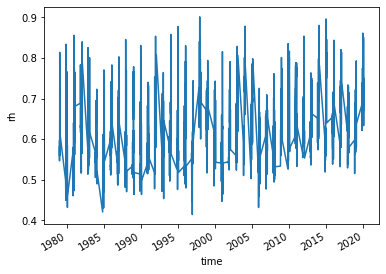

In [15]:
rh_ds.rh.values=rh_ds.rh.values*mask
#rh_ds.rh[:].mean(dim=['latitude','longitude'], skipna=True).plot()
rhTS=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh
rhTS.plot()

In [16]:
w700D.w.values=w700D.w.values*mask
w700D.mean(dim=['latitude','longitude'])
wTS=w700D.mean(dim=['latitude','longitude'], skipna=True).w[:,0]
#wTS.plot()

In [17]:
inv_ds.inv.values=inv_ds.inv.values*mask
invTS=inv_ds.mean(dim=['latitude','longitude'], skipna=True).inv
#invTS.plot()

In [18]:
ushear_ds.ushear.values=ushear_ds.ushear.values*mask
ushearTS=ushear_ds.mean(dim=['latitude','longitude'], skipna=True).ushear
#ushearTS.plot()

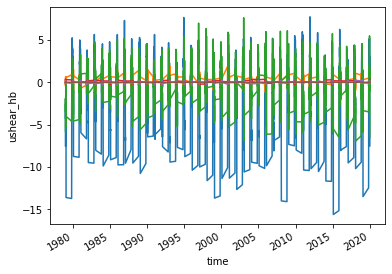

In [19]:
t2m_hb = np.imag(hilbert(t2mTS.values[(t2mTS.time.dt.year<2020)],axis=0))
t2m_hb_ds = xr.Dataset({'t2m_hb': (('time'), t2m_hb)}, coords={'time': t2mTS[(t2mTS.time.dt.year<2020)].time})
t2m_hb_ds.t2m_hb.plot()

ws_hb = np.imag(hilbert(wsTS.values[(wsTS.time.dt.year<2020)],axis=0))
ws_hb_ds = xr.Dataset({'ws_hb': (('time'), ws_hb)}, coords={'time': wsTS[(wsTS.time.dt.year<2020)].time})
ws_hb_ds.ws_hb.plot()

inv_hb = np.imag(hilbert(invTS.values[(invTS.time.dt.year<2020)],axis=0))
inv_hb_ds = xr.Dataset({'inv_hb': (('time'), inv_hb)}, coords={'time': invTS[(invTS.time.dt.year<2020)].time})
inv_hb_ds.inv_hb.plot()

rh_hb = np.imag(hilbert(rhTS.values[(rhTS.time.dt.year<2020)],axis=0))
rh_hb_ds = xr.Dataset({'rh_hb': (('time'), rh_hb)}, coords={'time': rhTS[(rhTS.time.dt.year<2020)].time})
rh_hb_ds.rh_hb.plot()

w_hb = np.imag(hilbert(wTS.values[(wTS.time.dt.year<2020)],axis=0))
w_hb_ds = xr.Dataset({'w_hb': (('time'), w_hb)}, coords={'time': wTS[(wTS.time.dt.year<2020)].time})
w_hb_ds.w_hb.plot()

ushear_hb = np.imag(hilbert(ushearTS.values[(ushearTS.time.dt.year<2020)],axis=0))
ushear_hb_ds = xr.Dataset({'ushear_hb': (('time'), ushear_hb)}, coords={'time': ushearTS[(ushearTS.time.dt.year<2020)].time})
ushear_hb_ds.ushear_hb.plot()

In [20]:
#Create area averaged values and get same days as fog days i.e. Dec Jan

# a,b = xr.align(fg.fogdata.sum(dim='stations'),t2mTS)

t2m=t2mTS[((t2mTS.time.dt.month>11) | (t2mTS.time.dt.month<2)) & (t2mTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

ws=wsTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

inv=invTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

rh=rhTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

w=wTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

ushear=ushearTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

#t2m

In [21]:
t2mhb=t2m_hb_ds.t2m_hb[((t2m_hb_ds.time.dt.month>11) | (t2m_hb_ds.time.dt.month<2)) & (t2m_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
invhb=inv_hb_ds.inv_hb[((inv_hb_ds.time.dt.month>11) | (inv_hb_ds.time.dt.month<2)) & (inv_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
wshb=ws_hb_ds.ws_hb[((ws_hb_ds.time.dt.month>11) | (ws_hb_ds.time.dt.month<2)) & (ws_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
rhhb=rh_hb_ds.rh_hb[((rh_hb_ds.time.dt.month>11) | (rh_hb_ds.time.dt.month<2)) & (rh_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
whb=w_hb_ds.w_hb[((w_hb_ds.time.dt.month>11) | (w_hb_ds.time.dt.month<2)) & (w_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
ushearhb=ushear_hb_ds.ushear_hb[((ushear_hb_ds.time.dt.month>11) | (ushear_hb_ds.time.dt.month<2)) & (ushear_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

In [22]:
#X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0,
#                        t2mhb.values,wshb.values,rhhb.values,invhb.values,whb.values,ushearhb.values]).T[:]

X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0]).T[:]


X.index = pd.to_datetime(t2m.time.values)
X

,0,1,2,3,4,5
1979-12-01 10:30:00,292.035095,1.834932,0.708859,6.891872,0.098325,0.090997
1979-12-02 10:30:00,292.056427,1.639527,0.666631,5.898264,0.054857,0.109640
1979-12-03 10:30:00,291.769226,1.591589,0.661128,5.731346,0.037788,0.106097
1979-12-04 10:30:00,291.208038,1.124852,0.657937,5.910801,-0.015733,0.087947
1979-12-05 10:30:00,291.743561,1.167518,0.646613,7.185572,-0.043891,0.093900
...,...,...,...,...,...,...
2019-01-27 10:30:00,286.516663,2.450720,0.678568,7.223832,0.064727,0.040415
2019-01-28 10:30:00,286.254028,2.626605,0.607172,6.774362,0.109470,0.074526
2019-01-29 10:30:00,286.247833,2.204186,0.581034,5.024248,0.153729,0.052181
2019-01-30 10:30:00,287.286652,1.269493,0.590043,3.832262,-0.003099,0.048707


In [23]:
norm = StandardScaler().fit(X)
    # transform training data
X = norm.transform(X)
X

array([[ 1.74202413,  0.19511287,  0.74293807,  1.61952367,  0.78485703,
        -0.69078492],
       [ 1.75285963, -0.22818772,  0.22563917,  1.11092022,  0.18603521,
        -0.52393938],
       [ 1.60697576, -0.33203462,  0.15822057,  1.02547886, -0.04910594,
        -0.55564852],
       ...,
       [-1.19761878,  0.99501958, -0.82295975,  0.66353281,  1.54809446,
        -1.03816638],
       [-0.66995042, -1.02978331, -0.71258784,  0.05338462, -0.61236769,
        -1.06925761],
       [ 0.03872803,  0.02571015, -0.12970089,  0.43280384, -2.58993619,
        -0.90348116]])

In [24]:
y=fg.fogdata.sum(dim='stations').sel(time=slice('1979-12-1','2019-1-31'))
#=y/25.0
y

<xarray.DataArray 'fogdata' (time: 2480)>
array([4., 3., 3., ..., 1., 1., 4.])
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2019-01-31

In [25]:
seed(0)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
reg= GradientBoostingRegressor(n_estimators=300, min_samples_leaf=20, max_depth= 3,learning_rate=0.04,random_state=0).fit(X_train, y_train)
regLin=LinearRegression().fit(X_train, y_train)
f_imp=reg.feature_importances_

print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))


print(regLin.score(X_train, y_train))
print(regLin.score(X_test, y_test))

0.6813302651507613
0.5902933647101759
0.4978121910662483
0.48770448221801876


[[1.         0.81606956]
 [0.81606956 1.        ]]
[[1.         0.82766556]
 [0.82766556 1.        ]]
[[1.         0.76845783]
 [0.76845783 1.        ]]


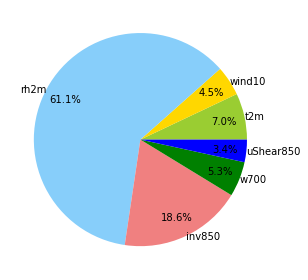

In [26]:

labels = ["t2m","wind10","rh2m","inv850","w700","uShear850"]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','green','blue','grey','red','brown','skyblue','yellow','pink']
plt.pie(f_imp, labels=labels,colors=colors, autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.0)
plt.tight_layout()
#plt.savefig('GradBoostAllDays.png')

y_pred=reg.predict(X)
y_pred_test=reg.predict(X_test)
y_pred_train=reg.predict(X_train)
y_predLin=regLin.predict(X)
print(np.corrcoef(y,y_pred))
print(np.corrcoef(y_train,y_pred_train))
print(np.corrcoef(y_test,y_pred_test))



# plot y obs and y_pred monthly

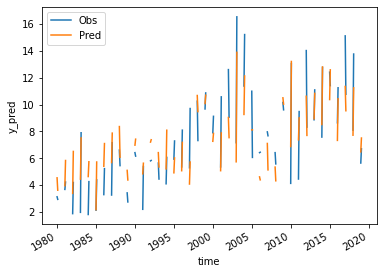

In [27]:
y_ds=xr.Dataset({'y': (('time'), y)}, coords={'time': t2m.time})
y_pred_ds=xr.Dataset({'y_pred': (('time'), y_pred)}, coords={'time': y.time})
y_predLin_ds=xr.Dataset({'y_predLin': (('time'), y_predLin)}, coords={'time': y.time})
y_ds.resample(time='1M').mean().y.plot(label='Obs')
y_pred_ds.resample(time='1M').mean().y_pred.plot(label='Pred')
plt.legend()

(0.816069561809324, 0.0)
(0.7043679110774017, 0.0)


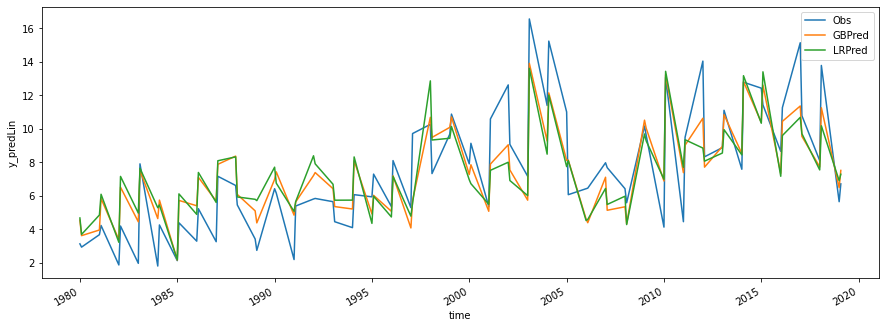

In [28]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1M').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1M').mean().y_pred.dropna(dim='time').plot(label='GBPred')
y_predLin_ds.resample(time='1M').mean().y_predLin.dropna(dim='time').plot(label='LRPred')
plt.legend()
#np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
print(stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values))
print(stats.pearsonr(y_ds.y.values, y_predLin_ds.y_predLin.values))
#y_ds.y.values.corr(y_pred_ds.y_pred.values)

# Read IPSL files

In [29]:
#Read Orography
I_OroData = xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/NDJF/orog_fx_ACCESS-CM2_historical_r1i1p1f1_gn.nc')
Ioro=I_OroData.orog.sel(lat=slice(24,32),lon=slice(74,86))
#Create Mask
Ioro.values[Ioro.values>500.1]=np.NaN
Imask=Ioro.values/Ioro.values

# IPSL T2m and T2m hilbert

In [30]:
#Read Data
I_t2mData= xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/NDJF/tas_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
It2mD = I_t2mData.sel(lat=slice(24,32),lon=slice(74,86))



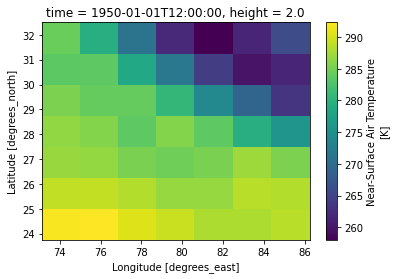

In [31]:
It2mD.tas[0,:,:].plot()

In [32]:
#Mask data
It2mD.tas.values=It2mD.tas.values*Imask
# area avg
It2mTS=It2mD.mean(dim=['lat','lon'], skipna=True).tas
#Hilbert transform
It2m_hb = np.imag(hilbert(It2mTS.values,axis=0))
It2m_hb_ds = xr.Dataset({'It2m_hb': (('time'), It2m_hb)}, coords={'time': It2mTS.time})
#ISelect only Dec Jan months
It2m=It2mTS[((It2mTS.time.dt.month>11) | (It2mTS.time.dt.month<2))]
It2mhb=It2m_hb_ds.It2m_hb[((It2m_hb_ds.time.dt.month>11) | (It2m_hb_ds.time.dt.month<2))] 


# IPSL wind speed and wind speed hilbert

In [33]:
# Read data
Iu10Data = xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/NDJF/uas_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
Iv10Data = xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/NDJF/vas_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
Iu10D = Iu10Data.sel(lat=slice(24,32),lon=slice(74,86))
Iv10D = Iv10Data.sel(lat=slice(24,32),lon=slice(74,86))
# Calculate wind speed
Iws = ((Iv10D.vas.values**2)+(Iu10D.uas.values**2))**0.5
Iws_ds = xr.Dataset({'Iws': (('time','lat','lon'), Iws)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})


In [43]:
Iv10D.lon.values

array([75.   , 76.875, 78.75 , 80.625, 82.5  , 84.375])

In [44]:
Iu10D.lon.values

array([75.   , 76.875, 78.75 , 80.625, 82.5  , 84.375])

In [45]:
It2mD.lon.values

array([74.0625, 75.9375, 77.8125, 79.6875, 81.5625, 83.4375, 85.3125])

In [46]:
Ioro.lon.values

array([74.0625, 75.9375, 77.8125, 79.6875, 81.5625, 83.4375, 85.3125])

In [47]:
Iws_ds.lon.values

array([75.   , 76.875, 78.75 , 80.625, 82.5  , 84.375])

In [37]:
#Mask
Iws_ds.Iws.values=Iws_ds.Iws.values*Imask
# area avg
IwsTS=Iws_ds.mean(dim=['lat','lon'], skipna=True).Iws
# hilbert
Iws_hb = np.imag(hilbert(IwsTS.values,axis=0))
Iws_hb_ds = xr.Dataset({'Iws_hb': (('time'), Iws_hb)}, coords={'time': IwsTS.time})
#Select Dec and Jan
Iws=IwsTS[((IwsTS.time.dt.month>11) | (IwsTS.time.dt.month<2))] 
Iwshb=Iws_hb_ds.Iws_hb[((Iws_hb_ds.time.dt.month>11) | (Iws_hb_ds.time.dt.month<2))]

ValueError: operands could not be broadcast together with shapes (7816,7,6) (7,7) 

# IPSL rh and rh hilbert

In [48]:
#Read Data
I_rhData= xr.open_dataset('../../../Data/CMIP6/ACCESS-CM2/NDJF/hurs_NDJFday_ACCESS-CM2_historical_r1i1p1f1_gn_19500101-20141231.nc')
IrhD = I_rhData.sel(lat=slice(24,32),lon=slice(74,86))
IrhD.hurs.values=IrhD.hurs.values/100.0


In [ ]:
#Mask data
IrhD.hurs.values=IrhD.hurs.values*Imask
# area avg
IrhTS=IrhD.mean(dim=['lat','lon'], skipna=True).hurs
#Hilbert transform
Irh_hb = np.imag(hilbert(IrhTS.values,axis=0))
Irh_hb_ds = xr.Dataset({'Irh_hb': (('time'), Irh_hb)}, coords={'time': IrhTS.time})
#ISelect only Dec Jan months
Irh=IrhTS[((IrhTS.time.dt.month>11) | (IrhTS.time.dt.month<2))]
Irhhb=Irh_hb_ds.Irh_hb[((Irh_hb_ds.time.dt.month>11) | (Irh_hb_ds.time.dt.month<2))] 
Irh.plot()
Irhhb.plot()

#  IPSL inv and inv hilbert

In [ ]:
# Read 850 hPa t
I_tLevData= xr.open_mfdataset('../../../Data/CMIP6/ACCESS-CM2/ta_*.nc')



In [ ]:
plev2=np.array([100000.,  85000.,  70000.,  50000., 25000.,  10000.,   5000.,   1000.])


plev2

In [ ]:
#I_tLevData.plev.values=[100000.,  85000.,  70000.,  50000., 25000.,  10000.,   5000.,   1000.]
I_tLevData=I_tLevData.assign_coords(plev=('plev',plev2))
I_tLevData.plev.values


In [ ]:
It850D=I_tLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
It850D.ta.values=It850D.ta.values*Imask

In [ ]:
It850D.ta

In [ ]:
# Calculate inv
Iinv = It2mD.tas.values-It850D.ta.values
Iinv_ds = xr.Dataset({'Iinv': (('time','lat','lon'), Iinv)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iinv_ds.Iinv
#Mask
Iinv_ds.Iinv.values=Iinv_ds.Iinv.values*Imask
# area avg
IinvTS=Iinv_ds.mean(dim=['lat','lon'], skipna=True).Iinv
# hilbert
Iinv_hb = np.imag(hilbert(IinvTS.values,axis=0))
Iinv_hb_ds = xr.Dataset({'Iinv_hb': (('time'), Iinv_hb)}, coords={'time': IinvTS.time})
#Select Dec and Jan
Iinv=IinvTS[((IinvTS.time.dt.month>11) | (IinvTS.time.dt.month<2))] 
Iinvhb=Iinv_hb_ds.Iinv_hb[((Iinv_hb_ds.time.dt.month>11) | (Iinv_hb_ds.time.dt.month<2))]



# IPSL w700 and w700 hilbert

In [ ]:
# Read Data
I_w700Data= xr.open_mfdataset('../../../Data/CMIP6/ACCESS-CM2/wap_*.nc')
Iw700D = I_w700Data.sel(lat=slice(24,32),lon=slice(74,86),plev=(70000))


In [ ]:
#Mask data
Iw700D.wap.values=Iw700D.wap.values*Imask
# area avg
Iw700TS=Iw700D.mean(dim=['lat','lon'], skipna=True).wap
#Hilbert transform
Iw700_hb = np.imag(hilbert(Iw700TS.values,axis=0))
Iw700_hb_ds = xr.Dataset({'Iw700_hb': (('time'), Iw700_hb)}, coords={'time': Iw700TS.time})
#ISelect only Dec Jan months
Iw700=Iw700TS[((Iw700TS.time.dt.month>11) | (Iw700TS.time.dt.month<2))]
Iw700hb=Iw700_hb_ds.Iw700_hb[((Iw700_hb_ds.time.dt.month>11) | (Iw700_hb_ds.time.dt.month<2))] 

# IPSL ushear and ushear hilbert

In [ ]:
# Read 850 hPa u 
I_uLevData= xr.open_mfdataset('../../../Data/CMIP6/ACCESS-CM2/ua_*.nc')
Iu850D=I_uLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Read 850 hPa  z 
I_zLevData= xr.open_mfdataset('../../../Data/CMIP6/ACCESS-CM2/zg_*.nc')
Iz850D=I_zLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Calculate ushear
Iushear = (Iu850D.ua.values-Iu10D.uas.values)/(Iz850D.zg.values) 
Iushear_ds = xr.Dataset({'Iushear': (('time','lat','lon'), Iushear)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Iushear_ds.Iushear[0,:,:].plot()
#Mask
Iushear_ds.Iushear.values=Iushear_ds.Iushear.values*Imask
# area avg
IushearTS=Iushear_ds.mean(dim=['lat','lon'], skipna=True).Iushear
# hilbert
Iushear_hb = np.imag(hilbert(IushearTS.values,axis=0))
Iushear_hb_ds = xr.Dataset({'Iushear_hb': (('time'), Iushear_hb)}, coords={'time': IushearTS.time})
#Select Dec and Jan
Iushear=IushearTS[((IushearTS.time.dt.month>11) | (IushearTS.time.dt.month<2))] 
Iushearhb=Iushear_hb_ds.Iushear_hb[((Iushear_hb_ds.time.dt.month>11) | (Iushear_hb_ds.time.dt.month<2))]
Iushearhb.plot()

In [ ]:
#IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0,
#                       It2mhb.values,Iwshb.values,Irhhb.values,Iinvhb.values,Iw700hb.values,Iushearhb.values]).T[:]
IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0]).T[:]

IX.index = pd.to_datetime(It2m.time.values)
IX

In [ ]:
normI = StandardScaler().fit(IX)
    # transform training data
IX = normI.transform(IX)
IX

In [ ]:
Iy_pred=reg.predict(IX)
Iy_predLin=regLin.predict(IX)
Iy_df = pd.DataFrame(Iy_pred)
Iy_df.index = pd.to_datetime(It2m.time.values)
Iy_dfLin = pd.DataFrame(Iy_predLin)
Iy_dfLin.index = pd.to_datetime(It2m.time.values)

In [ ]:
Iy_ds=xr.Dataset({'Iy_pred': (('time'), Iy_pred)}, coords={'time': It2m.time})
Iy_ds

IyLin_ds=xr.Dataset({'Iy_predLin': (('time'), Iy_predLin)}, coords={'time': It2m.time})
IyLin_ds

In [ ]:
Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time').plot(label='IPSL Pred')

In [ ]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1M').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1M').mean().y_pred.dropna(dim='time').plot(label='Pred')
Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time').plot(label='IPSL Pred GB')
IyLin_ds.resample(time='1M').mean().Iy_predLin.dropna(dim='time').plot(label='IPSL Pred LR')

plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)
#y_ds.y.values.corr(y_pred_ds.y_pred.values)

In [ ]:
Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time')

In [ ]:
plt.figure(figsize=[15,5])
#Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time').plot(label='Obs')
#y_pred_ds.resample(time='1M').mean().y_pred.dropna(dim='time').plot(label='Pred')
y_ds.resample(time='1M').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1M').mean().y_pred.dropna(dim='time').plot(label='Pred')
Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time')[260:].plot(label='IPSL Pred GB')
IyLin_ds.resample(time='1M').mean().Iy_predLin.dropna(dim='time')[260:].plot(label='IPSL Pred LR')

plt.legend()

# Standard Normal rh comparison



In [ ]:
normrh=xr.Dataset({'normrh': (('time'), scale(rh))}, coords={'time': rh.time})
normrh

Inormrh=xr.Dataset({'Inormrh': (('time'), scale(Irh))}, coords={'time': Irh.time})
Inormrh

In [ ]:
plt.figure(figsize=[15,5])
normrh.resample(time='1M').mean().normrh.dropna(dim='time').plot(label='Obs')
Inormrh.resample(time='1M').mean().Inormrh.dropna(dim='time').plot(label='IPSL')
#y_ds.resample(time='1M').mean().y.dropna(dim='time').plot(label='Obs')
#Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time')[260:].plot(label='IPSL Pred GB')

In [ ]:
plt.figure(figsize=[15,5])
normrh.resample(time='1M').mean().normrh.dropna(dim='time').plot(label='Obs')
Inormrh.resample(time='1M').mean().Inormrh.dropna(dim='time')[260:].plot(label='IPSL')
#y_ds.resample(time='1M').mean().y.dropna(dim='time').plot(label='Obs')
#Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time')[260:].plot(label='IPSL Pred GB')